#Clustering de datos de GPS con K-means
###Por Sergio Hernández Charpak
####Enunciado
Utilizando los datos de GPS de los usuarios vamos a realizar un análisis de clasificación usando: <b>k-means</b>. Para tener un buen resultado necesitaremos encontrar el número óptimo de clusters para los datos.

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


#### Conexion con la base posgres en Heroku
Para ello usamos la libreria <b>psycopg2</b>
http://initd.org/psycopg/docs/

In [ ]:
import psycopg2
import sys

In [3]:
con = psycopg2.connect(host='ec2-23-21-215-184.compute-1.amazonaws.com', database='d24hmpf2j1dcmb', user='yhgxfatitsbsux', port=5432, password='75lOcKaYggEsZilsEKONaeH6t7')
cur = con.cursor()

In [5]:
cur.execute('SELECT version()')
ver = cur.fetchone()
print ver

('PostgreSQL 9.4.7 on x86_64-unknown-linux-gnu, compiled by gcc (Ubuntu/Linaro 4.6.3-1ubuntu5) 4.6.3, 64-bit',)


In [6]:
cur.execute('SELECT * from tipousuario')
ver = cur.fetchall()

In [9]:
print (ver)

[(1, datetime.date(2016, 4, 18), 74.1, 4.1, 'Participante', datetime.date(2016, 4, 18), 'user1'), (2, datetime.date(2016, 4, 18), 74.1, 4.1, 'Participante', datetime.date(2016, 4, 18), 'user1'), (3, datetime.date(2016, 4, 18), 4.6033294, -74.0647774, 'Participante', datetime.date(2016, 4, 18), 'user1'), (4, datetime.date(2016, 4, 18), 4.603444, -74.0647579, 'Participante', datetime.date(2016, 4, 18), 'user1'), (5, datetime.date(2016, 4, 18), 4.6034177, -74.0647469, 'Participante', datetime.date(2016, 4, 18), 'user1'), (6, datetime.date(2016, 4, 18), 4.6034166, -74.0647732, 'Participante', datetime.date(2016, 4, 18), 'user1'), (7, datetime.date(2016, 4, 18), 4.6034092, -74.0647808, 'Participante', datetime.date(2016, 4, 18), 'user1'), (8, datetime.date(2016, 4, 18), 4.6034198, -74.0647655, 'Participante', datetime.date(2016, 4, 18), 'user1'), (9, datetime.date(2016, 4, 18), 4.6034463, -74.0647825, 'Participante', datetime.date(2016, 4, 18), 'user1'), (10, datetime.date(2016, 4, 18), 4.6

####Importación de los datos con Pandas
Primero que todo debemos importar los datos con pandas. Nos basamos en el super tutorial: http://tott-meetup.readthedocs.org/en/latest/ donde juegan con la calidad de los vinos. Acá nosotros cogemos los datos gps-data y no los de wine-quality que son los usados en el tutorial.


In [2]:
import pandas as pnd

In [76]:
data = pnd.read_sql_query('select * from "tipousuario"',con=con)

In [77]:
data.head()

,id,create_at,latitude,longitude,tipo,updated_at,username
0,1,2016-04-18,74.100000,4.100000,Participante,2016-04-18,user1
1,2,2016-04-18,74.100000,4.100000,Participante,2016-04-18,user1
2,3,2016-04-18,4.603329,-74.064777,Participante,2016-04-18,user1
3,4,2016-04-18,4.603444,-74.064758,Participante,2016-04-18,user1
4,5,2016-04-18,4.603418,-74.064747,Participante,2016-04-18,user1


En los datos tenemos las columnas:
<ul>
<li>id</li>
<li>create_at</li>
<li><b>latitude</b></li>
<li><b>longitude</b></li>
<li>tipo</li>
<li>updated_at</li>
<li>username</li>
</ul>

Indexamos las columnas

In [78]:
indexed_df = data.set_index(['id', 'create_at', 'latitude', 'longitude', 'tipo', 'updated_at','username'],[0, 1, 2, 3, 4, 5,6])

Seleccionamos las columnas latitude y longitude para hacer el analisis de K-means

In [79]:
gps_data = data[['latitude', 'longitude']]

In [80]:
gps_data.head()

,latitude,longitude
0,74.100000,4.100000
1,74.100000,4.100000
2,4.603329,-74.064777
3,4.603444,-74.064758
4,4.603418,-74.064747


Ahora pre-procecemos los datos

In [81]:
Y = np.ones(len(gps_data))

In [82]:
for i in range (len(gps_data)):
    longitude_i = gps_data['longitude'][i]
    if(longitude_i > 0.0):
        Y[i] = 2

In [83]:
from sklearn.preprocessing import scale

In [93]:
#X = scale(gps_data)
X = gps_data.values

Ya tenemos de un lado los datos normalizados (X) y por otro lado la clasificación ya hecha (Y).

## K-Means
### ¿cuántos clusters son el numero óptimo? 
<p> La documentación de K-Means se encuentra en: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html </p>

In [94]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [95]:
n_max_clusters = 10
inertias_kmeans = np.zeros(n_max_clusters)
silhouette_avg_kmeans = np.zeros(n_max_clusters)

Es dificil ver un error para esto. 
<p>Por ahora lo que tenemos es la propiedad de inertia_ que se define como:</p>
Sum of distances of samples to their closest cluster center.
<p>O sea es la suma de las distancias de los puntos con sus respectivos centroides de cluster</p>
Tambien vamos a ver el <b>silhouette score</b> para cada numero de clusters. Esta medida, definida aca http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html , esta relacionada con la reparticion de las distancias por cada cluster realizado. Entre más cercana a 1 significa que el cluster realizado es más uniforme (en otras palabras, bien hecho).

In [96]:
for i in range (1,n_max_clusters+1):
    #Hace el fit de K-Means
    das_estimator = KMeans(n_clusters=i)
    das_fit = das_estimator.fit(X,Y)
    das_predict = das_fit.predict(X)
    inertias_kmeans[i-1] = das_fit.inertia_
    if i!= 1:
        silhouette_avg_kmeans[i-1] = silhouette_score(X, das_predict)

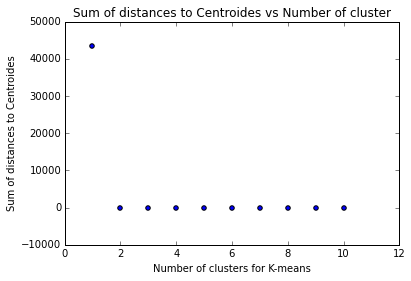

In [97]:
#Grafiquemos los resultados
x_chiquito = np.linspace(1,n_max_clusters,n_max_clusters)
fig = plt.figure()
plt.scatter(x_chiquito, inertias_kmeans)
plt.ylabel("Sum of distances to Centroides")
plt.xlabel("Number of clusters for K-means")
plt.title("Sum of distances to Centroides vs Number of cluster")

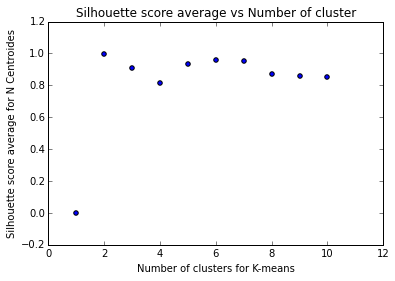

In [98]:
fig = plt.figure()
plt.scatter(x_chiquito, silhouette_avg_kmeans)
plt.ylabel("Silhouette score average for N Centroides")
plt.xlabel("Number of clusters for K-means")
plt.title("Silhouette score average vs Number of cluster")

In [110]:
silhoutte_max = np.max(silhouette_avg_kmeans)
silhoutte_max_arg = np.argmax(silhouette_avg_kmeans)
print silhoutte_max_arg + 1

2


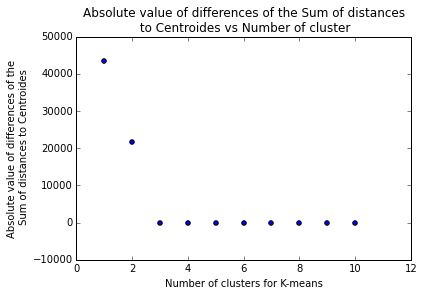

In [99]:
diff_inertias = np.abs(np.gradient(inertias_kmeans))
fig = plt.figure()
plt.scatter(x_chiquito, diff_inertias)
plt.ylabel("Absolute value of differences of the  \n Sum of distances to Centroides")
plt.xlabel("Number of clusters for K-means")
plt.title("Absolute value of differences of the Sum of distances \n to Centroides vs Number of cluster")

<p> Podemos observar que esta el cambio de esta "intertia" es muy alto hasta 2 clusters.</p>
<p> Tambien podemos ver que el silhouette score es alto hasta 2 clusters </p> 

Al observar estas diferencias podemos observar que a partir de 2 centroides se estabiliza alrededor de un valor minimo. <p> Por lo tanto el numero óptimo de clusters debe ser o <b> 2 o 3</b>. Debemos calcular la eficiencia de K-Means con 2 cluster y 3 clusters para decidir entre ambos. </p>
<p> Para determinar cual es mejor, hacemos un análisis de silhouette basado en: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html </p>

In [100]:
from sklearn.metrics import silhouette_samples, silhouette_score

('For n_clusters =', 2, 'The average silhouette_score is :', 0.99971289825696807)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.90617934630390873)


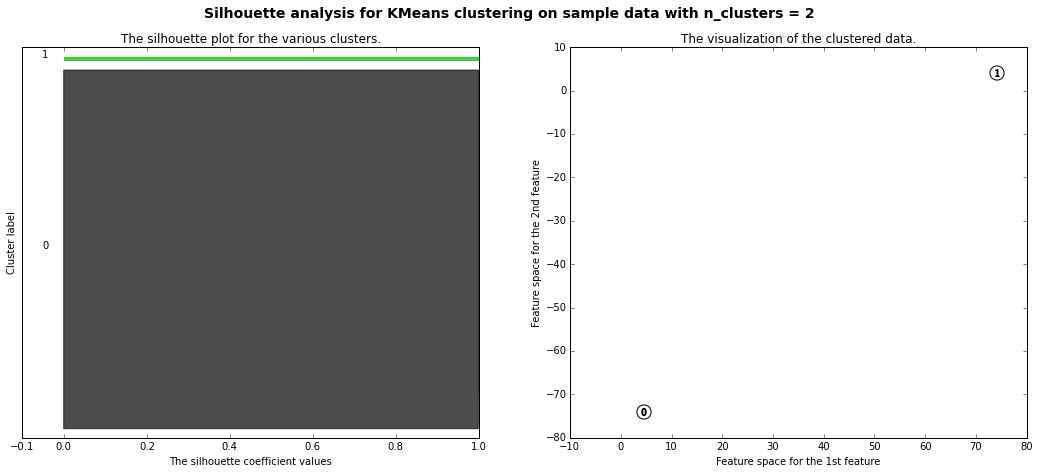

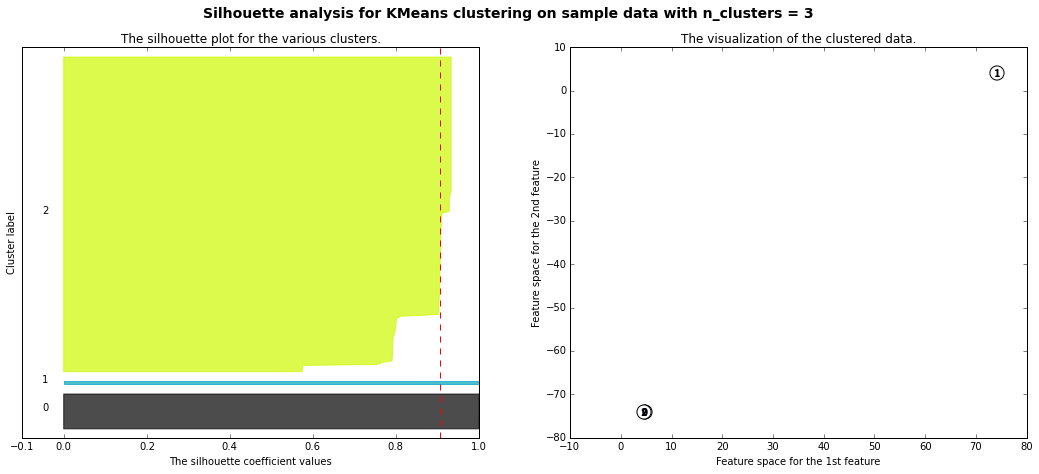

In [101]:
for n_clusters in range(2,4):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

<p>Podemos observar que para 3 clusters el cluster 2 está en su inmensa mayoria con un silhouette score por debajo de la media, mientras que para 2 clusters cada cluster tiene valores de silhouette por debajo y encima de la media. </p>
<p> Por lo tanto podemos concluir que el <b> número óptimo de clusters para K-Means es 2 </b> </p>

### Desempeño de K-means

Podemos calcular cuantos puntos quedan mal clasificados

In [111]:
#ya sabemos que 2 es el numero optimo
das_estimator = KMeans(n_clusters = silhoutte_max_arg + 1)
das_fit = das_estimator.fit(X,Y)
das_predict = das_fit.predict(X)
#Le sumamos 1 ya que da resultados en [0;2] cuando Y tiene valores en [1;3]
das_predict_Y = das_predict + 1
#y = Y.values

In [103]:
n_wrong_class = 0
for i in range (0, len(Y)):
    if Y[i] != das_predict_Y[i]:
        n_wrong_class += 1
print str(n_wrong_class) + " GPS quedaron mal clasificados."
porcentaje = 100 * float((len(Y) - n_wrong_class ))/ float(len(Y)) 
print "La eficiencia de K-Means es entonces: " + str(porcentaje)+"%"

0 GPS quedaron mal clasificados.
La eficiencia de K-Means es entonces: 100.0%


In [104]:
centers = das_estimator.cluster_centers_

In [108]:
print centers[0]

[  4.62533055 -74.06978932]
